Processing dataset: train_up3.csv
Loading data...
Loading train/test listing IDs...
Loaded 6291 train IDs and 1573 test IDs
Applying log transformation to price data
Creating calculated features...
Using 2 spatial features, 5 temporal features, 27 amenity features, and 15 price history features
Created 5 test periods:
  Period 1: 2024-01-05 to 2024-01-11
  Period 2: 2024-01-12 to 2024-01-18
  Period 3: 2024-01-19 to 2024-01-25
  Period 4: 2024-01-26 to 2024-02-01
  Period 5: 2024-02-02 to 2024-02-08
Using device: cuda

===== Split 1/5 =====
Training period: 2023-08-07 to 2024-01-04
Testing period: 2024-01-05 to 2024-01-11
Train data: 903142 rows, 6291 unique listings
Test data: 11011 rows, 1573 unique listings

----- Training GNN Model (Split 1) -----
Building enhanced spatial graph with 180551 test listings and 10 nearest neighbors...
Created graph with 3611020 edges
Created enhanced graph with 903142 nodes and 3611020 edges
Train nodes: 722591, Val nodes: 180551
Epoch 1/50 - Loss: 0.

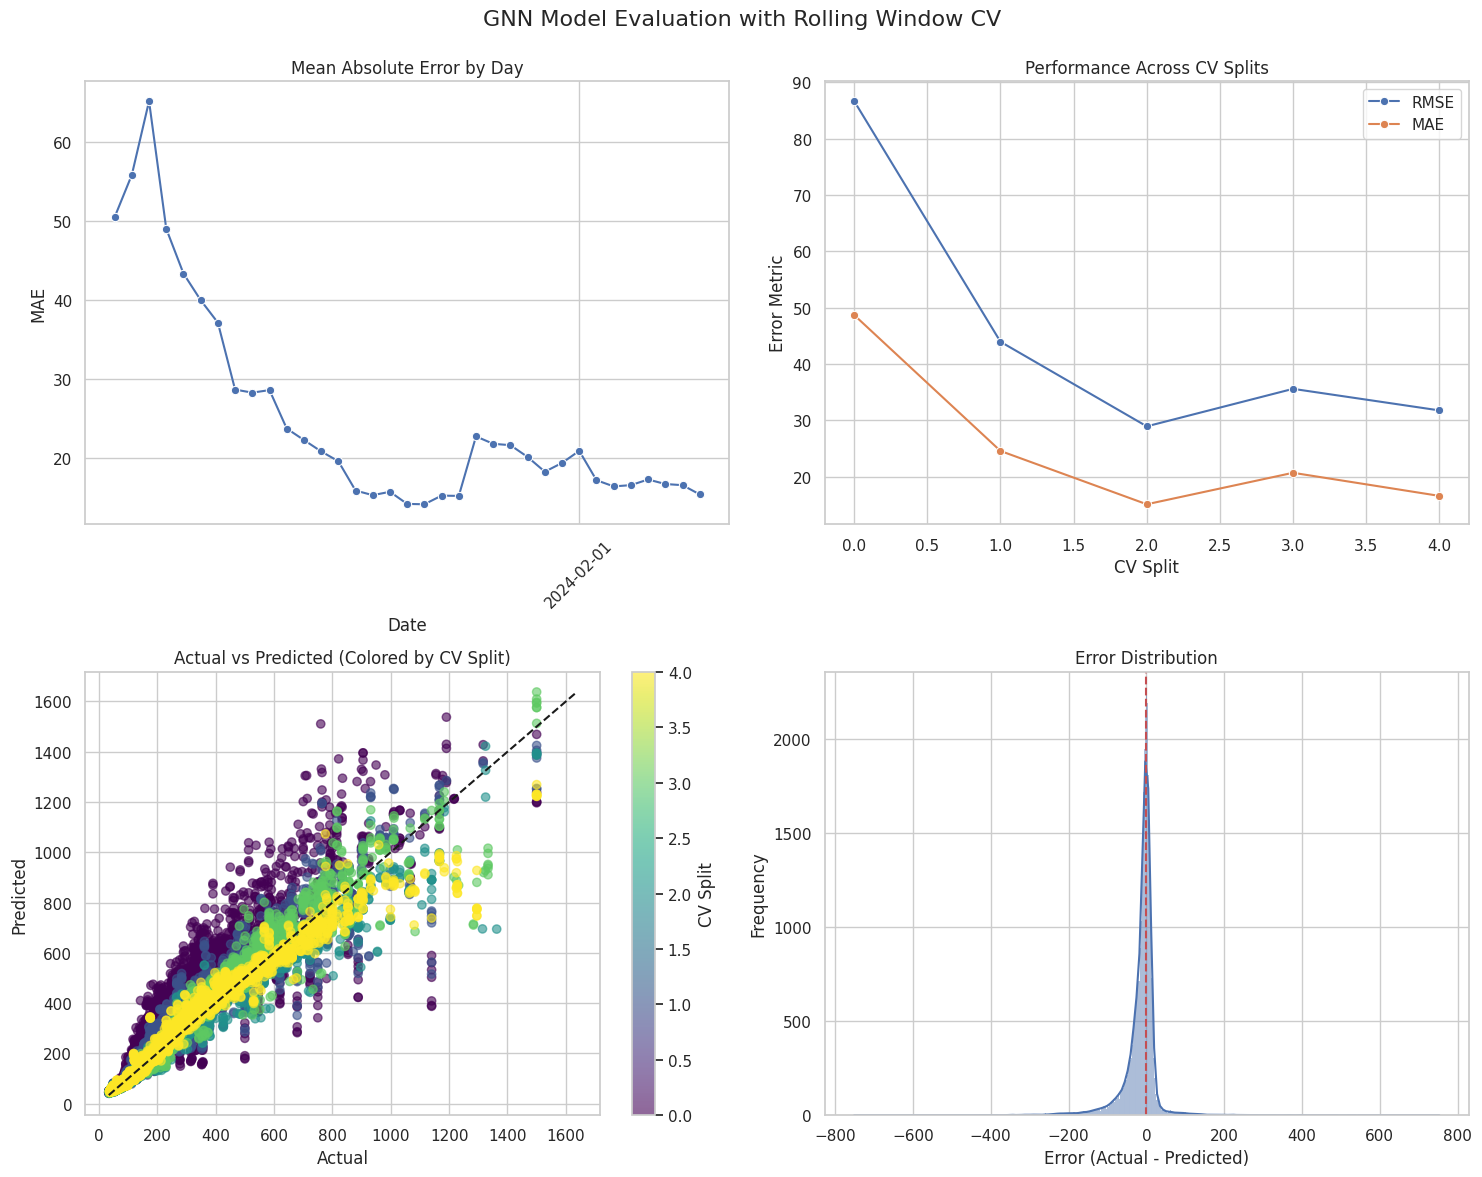

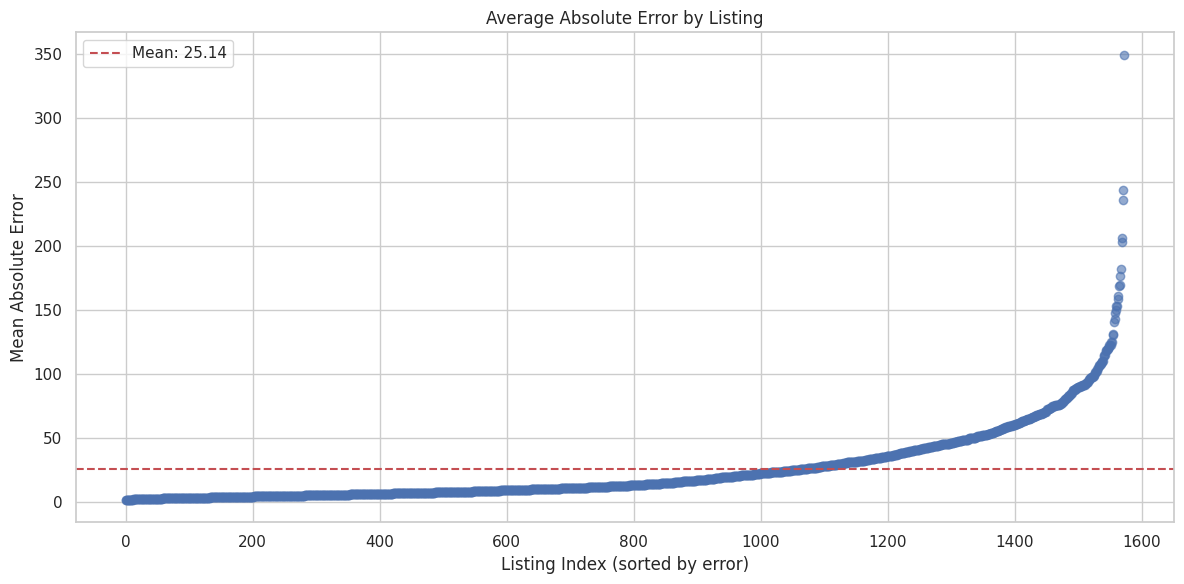

GNN model training with rolling window CV completed successfully!


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.dates as mdates
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
import warnings
warnings.filterwarnings('ignore')

# 1. Price transformation function
def apply_price_transformation(train_data, inverse=False):
    """
    Apply log transformation to price data or inverse the transformation
    
    Parameters:
    -----------
    train_data : DataFrame
        The dataframe containing price data
    inverse : bool
        If True, apply inverse transformation; otherwise apply log transformation
        
    Returns:
    --------
    DataFrame
        Modified dataframe with transformed prices
    """
    df = train_data.copy()
    
    if not inverse:
        # Apply log transformation
        print("Applying log transformation to price data")
        df['original_price'] = df['price']  # Store original price
        df['price'] = np.log1p(df['price'])  # log1p to handle zero values
    else:
        # Inverse transform
        print("Inverting log transformation for predictions")
        df['price'] = np.expm1(df['price'])  # expm1 is the inverse of log1p
    
    return df

# 2. Create calculated features (reuse from your existing code)
def create_calculated_features(df):
    """
    Adapt calculated features to work with provided dataset columns
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe to add features to
    
    Returns:
    --------
    DataFrame
        Modified dataframe with new features
    """
    # Create a copy to avoid modifying the original
    df_copy = df.copy()
    
    # Bedroom ratio
    if 'bedrooms' in df_copy.columns and 'accommodates' in df_copy.columns:
        df_copy['bedroom_ratio'] = df_copy['bedrooms'] / df_copy['accommodates'].clip(lower=1)
    
    # Count amenities
    amenity_columns = df_copy.filter(like='has_').columns
    if len(amenity_columns) > 0:
        df_copy['amenity_count'] = df_copy[amenity_columns].sum(axis=1)
    
    # Luxury score - use specific amenities from your dataset
    luxury_amenities = ['has_hot_water', 'has_hair_dryer', 'has_dedicated_workspace', 
                         'has_tv', 'has_wifi', 'has_shampoo']
    available_luxury = [col for col in luxury_amenities if col in df_copy.columns]
    
    if available_luxury:
        df_copy['luxury_score'] = df_copy[available_luxury].sum(axis=1) / len(available_luxury)
    else:
        df_copy['luxury_score'] = 0
    
    # Essential score - basic amenities that are essential
    essential_amenities = ['has_essentials', 'has_bed_linens', 'has_kitchen', 
                           'has_smoke_alarm', 'has_heating']
    available_essential = [col for col in essential_amenities if col in df_copy.columns]
    
    if available_essential:
        df_copy['essential_score'] = df_copy[available_essential].sum(axis=1) / len(available_essential)
    else:
        df_copy['essential_score'] = 0
    
    # Price volatility features based on rolling statistics
    if all(col in df_copy.columns for col in ['rolling_max_7d', 'rolling_min_7d']):
        df_copy['price_range_7d'] = df_copy['rolling_max_7d'] - df_copy['rolling_min_7d']
    
    if all(col in df_copy.columns for col in ['rolling_max_14d', 'rolling_min_14d']):
        df_copy['price_range_14d'] = df_copy['rolling_max_14d'] - df_copy['rolling_min_14d']
    
    if all(col in df_copy.columns for col in ['rolling_max_30d', 'rolling_min_30d']):
        df_copy['price_range_30d'] = df_copy['rolling_max_30d'] - df_copy['rolling_min_30d']
    
    # Fill any NaN values that might have been created
    numeric_cols = df_copy.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        if df_copy[col].isnull().any():
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    
    return df_copy

# 3. Build enhanced spatial graph for GNN
def build_enhanced_spatial_graph(train_data, test_data, k=10, feature_weight=0.3):
    """
    Build a graph with edge weights based on both geographic and feature similarity
    """
    # Extract coordinates
    train_coords = train_data[['latitude', 'longitude']].values
    test_coords = test_data[['latitude', 'longitude']].values
    
    print(f"Building enhanced spatial graph with {len(test_coords)} test listings and {k} nearest neighbors...")
    
    # Extract and normalize key features for similarity calculation
    features = ['accommodates', 'bedrooms', 'bathrooms']
    available_features = [f for f in features if f in train_data.columns]
    
    if available_features:
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_data[available_features].fillna(0))
        test_features = scaler.transform(test_data[available_features].fillna(0))
    else:
        # Fallback if no features are available
        print("Warning: No property features available for similarity calculation")
        train_features = np.ones((len(train_coords), 1))
        test_features = np.ones((len(test_coords), 1))
    
    # Find k nearest neighbors for each test listing
    nn = NearestNeighbors(n_neighbors=min(k, len(train_coords)))
    nn.fit(train_coords)
    distances, indices = nn.kneighbors(test_coords)
    
    # Create edge indices and attributes
    edge_index = []
    edge_attr = []
    
    for test_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(indices, distances)):
        test_feat = test_features[test_idx]
        
        for train_idx, distance in zip(neighbor_indices, neighbor_distances):
            # Calculate feature similarity (cosine similarity)
            train_feat = train_features[train_idx]
            feat_norm_product = np.linalg.norm(test_feat) * np.linalg.norm(train_feat)
            
            if feat_norm_product > 1e-8:  # Avoid division by zero
                feat_sim = np.dot(test_feat, train_feat) / feat_norm_product
            else:
                feat_sim = 0.0
            
            # Normalize distance for better numerical stability
            geo_weight = 1.0 / (distance + 1e-6)
            
            # Combined weight: (1-α) * geo_weight + α * feature_weight
            combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
            
            # Add edge from test listing to train listing
            edge_index.append([test_idx + len(train_data), train_idx])
            edge_attr.append([combined_weight])
            
            # Add reverse edge
            edge_index.append([train_idx, test_idx + len(train_data)])
            edge_attr.append([combined_weight])
    
    # Add edges between training listings (optional, can help propagate information)
    if len(train_coords) <= 5000:  # Only for smaller datasets to avoid memory issues
        train_nn = NearestNeighbors(n_neighbors=min(5, len(train_coords) - 1))
        train_nn.fit(train_coords)
        train_distances, train_indices = train_nn.kneighbors(train_coords)
        
        for train_idx, (neighbor_indices, neighbor_distances) in enumerate(zip(train_indices, train_distances)):
            for neighbor_idx, distance in zip(neighbor_indices, neighbor_distances):
                if train_idx != neighbor_idx:  # Skip self-loops
                    # Calculate feature similarity
                    train_feat_i = train_features[train_idx]
                    train_feat_j = train_features[neighbor_idx]
                    
                    feat_norm_product = np.linalg.norm(train_feat_i) * np.linalg.norm(train_feat_j)
                    if feat_norm_product > 1e-8:
                        feat_sim = np.dot(train_feat_i, train_feat_j) / feat_norm_product
                    else:
                        feat_sim = 0.0
                    
                    geo_weight = 1.0 / (distance + 1e-6)
                    combined_weight = (1 - feature_weight) * geo_weight + feature_weight * max(0, feat_sim)
                    
                    edge_index.append([train_idx, neighbor_idx])
                    edge_attr.append([combined_weight])
    
    # Convert to tensors with explicit dtype
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr_tensor = torch.tensor(edge_attr, dtype=torch.float32)
    
    print(f"Created graph with {edge_index_tensor.shape[1]} edges")
    
    return edge_index_tensor, edge_attr_tensor

# 4. Enhanced GNN model
class EnhancedSpatioTemporalGNN(nn.Module):
    def __init__(self, 
                 spatial_features_dim,
                 temporal_features_dim,
                 amenity_features_dim,
                 price_history_features_dim,  # New parameter for price history features
                 hidden_dim=64,
                 dropout=0.3,
                 heads=4,
                 edge_dim=1):
        super(EnhancedSpatioTemporalGNN, self).__init__()
        
        # For multi-head attention, ensure hidden_dim is divisible by heads
        self.h_dim = hidden_dim
        self.heads = heads
        self.head_dim = hidden_dim // heads
        
        # Important: Make sure the output dimension is consistent
        gat_out_dim = self.head_dim * heads  # This ensures exact dimensions
        
        # Replace GCN with GAT for better spatial relationship modeling
        self.gat1 = GATv2Conv(spatial_features_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        self.gat2 = GATv2Conv(gat_out_dim, self.head_dim, heads=heads, edge_dim=edge_dim)
        
        # Add batch normalization for more stable training - USING EXACT OUTPUT DIMENSIONS
        self.bn1 = nn.BatchNorm1d(gat_out_dim)
        self.bn2 = nn.BatchNorm1d(gat_out_dim)
        
        # Enhanced temporal processing
        self.temporal_layer1 = nn.Linear(temporal_features_dim, hidden_dim)
        self.temporal_bn1 = nn.BatchNorm1d(hidden_dim)
        self.temporal_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.temporal_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Enhanced amenity processing with residual connection
        self.amenity_layer1 = nn.Linear(amenity_features_dim, hidden_dim)
        self.amenity_bn1 = nn.BatchNorm1d(hidden_dim)
        self.amenity_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.amenity_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # New: Price history features processing
        self.price_history_layer1 = nn.Linear(price_history_features_dim, hidden_dim)
        self.price_history_bn1 = nn.BatchNorm1d(hidden_dim)
        self.price_history_layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.price_history_bn2 = nn.BatchNorm1d(hidden_dim)
        
        # Feature fusion mechanism - updated for 4 feature types
        self.fusion_weights = nn.Parameter(torch.ones(4, hidden_dim))
        self.fusion_bias = nn.Parameter(torch.zeros(hidden_dim))
        
        # Final prediction layers with residual connections
        self.fc1 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc1_bn = nn.BatchNorm1d(hidden_dim * 2)
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2_bn = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
        self.dropout = nn.Dropout(dropout)
        self.dropout_heavy = nn.Dropout(dropout + 0.1)
        
        # Optional dimension adjustment if needed
        self.dim_adjust = None
        if gat_out_dim != hidden_dim:
            self.dim_adjust = nn.Linear(gat_out_dim, hidden_dim)
    
    def forward(self, data):
        # Unpack the PyG data object - updated to include price_history_x
        x, edge_index, edge_attr, temporal_x, amenity_x, price_history_x = (
            data.x, data.edge_index, data.edge_attr, data.temporal_x, 
            data.amenity_x, data.price_history_x
        )
        
        # First GAT layer with batch normalization and residual
        spatial_features = self.gat1(x, edge_index, edge_attr=edge_attr)
        spatial_features = F.elu(spatial_features)
        spatial_features = self.bn1(spatial_features)
        spatial_features = self.dropout(spatial_features)
        
        # Second GAT layer
        spatial_features_res = spatial_features
        spatial_features = self.gat2(spatial_features, edge_index, edge_attr=edge_attr)
        spatial_features = self.bn2(spatial_features)
        
        # Add residual connection if dimensions match
        if spatial_features.shape == spatial_features_res.shape:
            spatial_features = spatial_features + spatial_features_res
        
        # Apply dimension adjustment if needed
        if self.dim_adjust is not None:
            spatial_features = self.dim_adjust(spatial_features)
        
        # Process temporal features with enhanced layers
        temporal_features = F.elu(self.temporal_layer1(temporal_x))
        temporal_features = self.temporal_bn1(temporal_features)
        temporal_features = self.dropout(temporal_features)
        temporal_features_res = temporal_features
        temporal_features = F.elu(self.temporal_layer2(temporal_features))
        temporal_features = self.temporal_bn2(temporal_features)
        temporal_features = temporal_features + temporal_features_res  # Residual connection
        
        # Process amenity features with residual connection
        amenity_features = F.elu(self.amenity_layer1(amenity_x))
        amenity_features = self.amenity_bn1(amenity_features)
        amenity_features = self.dropout(amenity_features)
        amenity_features_res = amenity_features
        amenity_features = F.elu(self.amenity_layer2(amenity_features))
        amenity_features = self.amenity_bn2(amenity_features)
        amenity_features = amenity_features + amenity_features_res  # Residual connection
        
        # Process price history features with residual connection
        price_history_features = F.elu(self.price_history_layer1(price_history_x))
        price_history_features = self.price_history_bn1(price_history_features)
        price_history_features = self.dropout(price_history_features)
        price_history_res = price_history_features
        price_history_features = F.elu(self.price_history_layer2(price_history_features))
        price_history_features = self.price_history_bn2(price_history_features)
        price_history_features = price_history_features + price_history_res  # Residual connection
        
        # Dynamic feature fusion with learned weights
        normalized_weights = F.softmax(self.fusion_weights, dim=0)
        
        # Apply weights to each feature type - now including price history
        fused_features = (
            spatial_features * normalized_weights[0] +
            temporal_features * normalized_weights[1] +
            amenity_features * normalized_weights[2] +
            price_history_features * normalized_weights[3] +
            self.fusion_bias
        )
        
        # Final prediction with residual connections
        out = F.elu(self.fc1(fused_features))
        out = self.fc1_bn(out)
        out = self.dropout(out)
        
        out = F.elu(self.fc2(out))
        out = self.fc2_bn(out)
        out = self.dropout_heavy(out)
        
        price_prediction = self.fc3(out)
        
        return price_prediction

# 5. Function to prepare graph data
def prepare_enhanced_graph(train_data, val_data, spatial_features, temporal_features, 
                          amenity_features, price_history_features, spatial_scaler, 
                          temporal_scaler, amenity_scaler, price_history_scaler, target_scaler,
                          device, k=10, feature_weight=0.3):
    """
    Prepare a combined graph with both train and validation listings using enhanced features
    """
    # Scale features and convert to float32
    X_train_spatial = spatial_scaler.transform(train_data[spatial_features].values).astype(np.float32)
    X_train_temporal = temporal_scaler.transform(train_data[temporal_features].values).astype(np.float32)
    X_train_amenity = amenity_scaler.transform(train_data[amenity_features].values).astype(np.float32)
    X_train_price_history = price_history_scaler.transform(train_data[price_history_features].values).astype(np.float32)
    y_train = target_scaler.transform(train_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    X_val_spatial = spatial_scaler.transform(val_data[spatial_features].values).astype(np.float32)
    X_val_temporal = temporal_scaler.transform(val_data[temporal_features].values).astype(np.float32)
    X_val_amenity = amenity_scaler.transform(val_data[amenity_features].values).astype(np.float32)
    X_val_price_history = price_history_scaler.transform(val_data[price_history_features].values).astype(np.float32)
    y_val = target_scaler.transform(val_data['price'].values.reshape(-1, 1)).flatten().astype(np.float32)
    
    # Combine train and val features
    X_combined_spatial = np.vstack([X_train_spatial, X_val_spatial])
    X_combined_temporal = np.vstack([X_train_temporal, X_val_temporal])
    X_combined_amenity = np.vstack([X_train_amenity, X_val_amenity])
    X_combined_price_history = np.vstack([X_train_price_history, X_val_price_history])
    
    # Create combined y with placeholder values for validation
    y_combined = np.zeros(len(X_combined_spatial), dtype=np.float32)
    y_combined[:len(y_train)] = y_train
    
    # Build enhanced spatial graph with feature similarity
    edge_index, edge_attr = build_enhanced_spatial_graph(
        train_data[['latitude', 'longitude'] + [f for f in ['accommodates', 'bedrooms', 'bathrooms'] if f in train_data.columns]], 
        val_data[['latitude', 'longitude'] + [f for f in ['accommodates', 'bedrooms', 'bathrooms'] if f in val_data.columns]], 
        k=k,
        feature_weight=feature_weight
    )
    
    # Create PyG data object with explicit float32 tensors
    data = Data(
        x=torch.FloatTensor(X_combined_spatial).to(device),
        edge_index=edge_index.to(device),
        edge_attr=edge_attr.to(device),
        temporal_x=torch.FloatTensor(X_combined_temporal).to(device),
        amenity_x=torch.FloatTensor(X_combined_amenity).to(device),
        price_history_x=torch.FloatTensor(X_combined_price_history).to(device),
        y=torch.FloatTensor(y_combined.reshape(-1, 1)).to(device),
        train_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_mask=torch.zeros(len(X_combined_spatial), dtype=torch.bool).to(device),
        val_y=torch.FloatTensor(y_val.reshape(-1, 1)).to(device),
    )
    
    # Set masks after creation
    data.train_mask[:len(X_train_spatial)] = True
    data.val_mask[len(X_train_spatial):] = True
    data.val_indices = torch.nonzero(data.val_mask).squeeze().to(device)
    
    print(f"Created enhanced graph with {len(X_combined_spatial)} nodes and {edge_index.shape[1]} edges")
    print(f"Train nodes: {data.train_mask.sum().item()}, Val nodes: {data.val_mask.sum().item()}")
    
    return data

# 6. Function to train GNN model
def train_gnn_model(train_data, val_data, spatial_features, temporal_features, amenity_features, 
                   price_history_features, hidden_dim=64, epochs=50, lr=0.001, device='cuda', batch_size=64):
    """
    Train GNN model with log-transformed prices and price history features
    """
    # Initialize scalers
    spatial_scaler = StandardScaler()
    temporal_scaler = StandardScaler()
    amenity_scaler = StandardScaler()
    price_history_scaler = StandardScaler()  # New scaler for price history
    target_scaler = StandardScaler()
    
    # Fit scalers on training data
    spatial_scaler.fit(train_data[spatial_features])
    temporal_scaler.fit(train_data[temporal_features])
    amenity_scaler.fit(train_data[amenity_features])
    price_history_scaler.fit(train_data[price_history_features])
    target_scaler.fit(train_data['price'].values.reshape(-1, 1))
    
    # Prepare graph data
    graph_data = prepare_enhanced_graph(
        train_data, val_data, spatial_features, temporal_features, amenity_features,
        price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
        price_history_scaler, target_scaler, device
    )
    
    # Initialize model
    model = EnhancedSpatioTemporalGNN(
        spatial_features_dim=len(spatial_features),
        temporal_features_dim=len(temporal_features),
        amenity_features_dim=len(amenity_features),
        price_history_features_dim=len(price_history_features),
        hidden_dim=hidden_dim,
        dropout=0.3,
        heads=4,
        edge_dim=1
    ).to(device)
    
    # Initialize optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )
    
    # Training loop
    best_val_loss = float('inf')
    best_model_state = None
    patience = 10
    counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        out = model(graph_data)
        
        # Get outputs for training nodes only
        train_out = out[graph_data.train_mask]
        train_y = graph_data.y[graph_data.train_mask]
        
        # Calculate loss
        loss = criterion(train_out, train_y)
        
        # Backward pass and optimize
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            # Forward pass
            val_out = model(graph_data)[graph_data.val_mask]
            val_y = graph_data.val_y
            
            # Calculate validation loss
            val_loss = criterion(val_out, val_y)
            
            # Convert predictions back to original scale for metrics
            val_pred_orig = np.expm1(target_scaler.inverse_transform(val_out.cpu().numpy()))
            val_true_orig = np.expm1(target_scaler.inverse_transform(val_y.cpu().numpy()))
            
            # Calculate metrics on original scale
            val_rmse = np.sqrt(mean_squared_error(val_true_orig, val_pred_orig))
            val_mae = mean_absolute_error(val_true_orig, val_pred_orig)
            
        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
              f"RMSE: {val_rmse:.2f}, MAE: {val_mae:.2f}")
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler

# 7. Function to make predictions with GNN
def predict_with_gnn(model, test_data, spatial_features, temporal_features, amenity_features, 
                     price_history_features, spatial_scaler, temporal_scaler, amenity_scaler, 
                     price_history_scaler, target_scaler, train_data, device):
    """
    Make predictions using the trained GNN model
    """
    # Prepare graph data with test data as validation
    graph_data = prepare_enhanced_graph(
        train_data, test_data, spatial_features, temporal_features, amenity_features,
        price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
        price_history_scaler, target_scaler, device
    )
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        predictions = model(graph_data)[graph_data.val_mask]
        
        # Transform back to original scale
        predictions_np = target_scaler.inverse_transform(predictions.cpu().numpy())
        
        # Inverse log transformation
        predictions_orig = np.expm1(predictions_np)
        
    return predictions_orig

# 8. Function to evaluate predictions
def evaluate_gnn_predictions(y_true, y_pred, print_results=True):
    """
    Evaluate GNN predictions using multiple metrics
    """
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    # Store metrics in dictionary
    metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }
    
    # Print results if requested
    if print_results:
        print("=== GNN Model Evaluation ===")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        print(f"MAPE: {mape:.2f}%")
    
    return metrics

# 9. Function to plot results
def plot_gnn_results(y_true, y_pred, history=None, output_dir=None):
    """
    Plot GNN prediction results
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    
    # Plot 2: Error Distribution
    plt.subplot(2, 2, 2)
    errors = y_true - y_pred
    plt.hist(errors, bins=50, alpha=0.7)
    plt.axvline(0, color='r', linestyle='--')
    plt.title('Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    
    # Plot 3: Error vs Actual Price
    plt.subplot(2, 2, 3)
    plt.scatter(y_true, errors, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Error vs Actual Price')
    plt.xlabel('Actual Price')
    plt.ylabel('Error')
    
    # Plot 4: Percentage Error Distribution
    plt.subplot(2, 2, 4)
    pct_errors = np.abs(errors / (y_true + 1e-8)) * 100
    plt.hist(pct_errors, bins=50, alpha=0.7)
    plt.axvline(np.median(pct_errors), color='r', linestyle='--', 
              label=f'Median: {np.median(pct_errors):.2f}%')
    plt.title('Percentage Error Distribution')
    plt.xlabel('Percentage Error')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    
    # Save plot if output_dir is provided
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'gnn_results.png'))
        print(f"Plot saved to {os.path.join(output_dir, 'gnn_results.png')}")
    
    plt.show()

# 10. Main function to run the GNN model
def run_strap_with_gnn(train_path, train_ids_path, test_ids_path, output_dir=None, sample_size=None):
    """
    Run enhanced STRAP model with GNN, log-transformed prices, and price history features
    """
    # Create output directory if not exists
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Load listing IDs for train/test split
    print("Loading train/test listing IDs...")
    with open(train_ids_path, 'r') as f:
        train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
    with open(test_ids_path, 'r') as f:
        test_listing_ids = [int(line.strip()) for line in f.readlines()]
    
    print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        np.random.seed(42)
        selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.7), replace=False)
        selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.3), replace=False)
        train_listing_ids = selected_train.tolist()
        test_listing_ids = selected_test.tolist()
    
    # Convert date column to datetime if needed
    if 'date' in train_data.columns and not pd.api.types.is_datetime64_any_dtype(train_data['date']):
        train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Create calculated features
    print("Creating calculated features...")
    train_data = create_calculated_features(train_data)
    
    # Check for NaN values in the dataset and fill them
    nan_columns = train_data.columns[train_data.isna().any()].tolist()
    if nan_columns:
        print(f"Warning: Found NaN values in columns: {nan_columns}")
        print("Filling NaN values with column means/medians")
        
        for col in nan_columns:
            if np.issubdtype(train_data[col].dtype, np.number):
                # Fill with median for numeric columns
                train_data[col] = train_data[col].fillna(train_data[col].median())
            else:
                # For non-numeric, fill with mode
                train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    
    # Split data into train and test based on listing IDs
    train_mask = train_data['listing_id'].isin(train_listing_ids)
    test_mask = train_data['listing_id'].isin(test_listing_ids)
    
    train_df = train_data[train_mask].copy()
    test_df = train_data[test_mask].copy()
    
    print(f"Train data: {len(train_df)} rows, {len(train_df['listing_id'].unique())} unique listings")
    print(f"Test data: {len(test_df)} rows, {len(test_df['listing_id'].unique())} unique listings")
    
    # Define feature groups based on your dataset columns
    spatial_features = [
        'latitude', 'longitude'
    ]
    
    # Temporal features - using your DTF prefixed features
    temporal_features = [
        'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend',
        'DTF_season_sin', 'DTF_season_cos'
    ]
    
    # Amenity features - all has_* columns plus accommodates, bedrooms, bathrooms
    amenity_features = [col for col in train_df.columns if col.startswith('has_')]
    basic_property_features = ['accommodates', 'bedrooms', 'bathrooms']
    available_basic_features = [f for f in basic_property_features if f in train_df.columns]
    amenity_features.extend(available_basic_features)
    
    # New: Price history features - price lags and rolling statistics
    price_history_features = [
        'price_lag_7d', 'price_lag_14d', 'price_lag_30d',
        'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d',
        'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d',
        'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d',
        
    ]
    
    # Ensure all feature lists only contain columns that exist in the dataset
    spatial_features = [f for f in spatial_features if f in train_df.columns]
    temporal_features = [f for f in temporal_features if f in train_df.columns]
    amenity_features = [f for f in amenity_features if f in train_df.columns]
    price_history_features = [f for f in price_history_features if f in train_df.columns]
    
    # If any feature group is empty, create dummy features
    if not amenity_features:
        print("No amenity features found, creating dummy feature")
        train_df['dummy_amenity'] = 1
        test_df['dummy_amenity'] = 1
        amenity_features = ['dummy_amenity']
    
    if not price_history_features:
        print("No price history features found, creating dummy feature")
        train_df['dummy_price_history'] = 1
        test_df['dummy_price_history'] = 1
        price_history_features = ['dummy_price_history']
    
    print(f"Using {len(spatial_features)} spatial features, {len(temporal_features)} temporal features, "
          f"{len(amenity_features)} amenity features, and {len(price_history_features)} price history features")
    
    # Apply log transformation to prices
    train_df = apply_price_transformation(train_df)
    test_df = apply_price_transformation(test_df)
    
    # Split train data into train and validation
    unique_train_listings = train_df['listing_id'].unique()
    train_listings, val_listings = train_test_split(
        unique_train_listings, test_size=0.2, random_state=42
    )
    
    train_subset = train_df[train_df['listing_id'].isin(train_listings)].copy()
    val_subset = train_df[train_df['listing_id'].isin(val_listings)].copy()
    
    print(f"Train subset: {len(train_subset)} rows, {len(train_listings)} listings")
    print(f"Validation subset: {len(val_subset)} rows, {len(val_listings)} listings")
    
    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Train GNN model
    print("\n===== Training GNN Model =====")
    gnn_model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler = train_gnn_model(
        train_subset, val_subset, spatial_features, temporal_features, amenity_features,
        price_history_features, hidden_dim=64, epochs=50, lr=0.001, device=device
    )
    
    # Return model and scalers to be used for predictions
    return gnn_model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler

# Add this function to implement rolling window CV for the GNN model
def run_gnn_with_rolling_window_cv(train_path, train_ids_path, test_ids_path, output_dir=None, 
                                   window_size=35, n_splits=5, sample_size=None):
    """
    Run GNN model with rolling window cross-validation
    
    Parameters:
    -----------
    train_path : str
        Path to the training CSV file
    train_ids_path : str
        Path to text file with training listing IDs
    test_ids_path : str
        Path to text file with test listing IDs
    output_dir : str, optional
        Directory to save results
    window_size : int, optional
        Size of the rolling window in days
    n_splits : int, optional
        Number of splits for time series cross-validation
    sample_size : int, optional
        Limit dataset to this number of random listings (for testing)
    """
    print(f"Processing dataset: {os.path.basename(train_path)}")
    
    # Create output directory if not exists
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Load training data
    print("Loading data...")
    train_data = pd.read_csv(train_path)

    # Load listing IDs for train/test split
    print("Loading train/test listing IDs...")
    with open(train_ids_path, 'r') as f:
        train_listing_ids = [int(line.strip()) for line in f.readlines()]
        
    with open(test_ids_path, 'r') as f:
        test_listing_ids = [int(line.strip()) for line in f.readlines()]
    
    print(f"Loaded {len(train_listing_ids)} train IDs and {len(test_listing_ids)} test IDs")

    # Drop legacy price columns if they exist
    price_cols_to_remove = ['price_lag_1d', 'simulated_price']
    
    for col in price_cols_to_remove:
        if col in train_data.columns:
            print(f"Dropping {col} column from the dataset")
            train_data = train_data.drop(col, axis=1)
    
    # For testing - take only a small sample of listings if specified
    if sample_size:
        print(f"Limiting to {sample_size} random listings for testing")
        np.random.seed(42)
        selected_train = np.random.choice(train_listing_ids, int(sample_size * 0.7), replace=False)
        selected_test = np.random.choice(test_listing_ids, int(sample_size * 0.3), replace=False)
        train_listing_ids = selected_train.tolist()
        test_listing_ids = selected_test.tolist()
    
    # Convert date column to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    
    # Filter data to include only dates from 7/8/23 till 2/8/24
    start_date = pd.to_datetime('2023-07-08')
    end_date = pd.to_datetime('2024-02-08')
    train_data = train_data[(train_data['date'] >= start_date) & (train_data['date'] <= end_date)]
    
    # Apply log transformation to price
    train_data = apply_price_transformation(train_data)
    
    # Create calculated features
    print("Creating calculated features...")
    train_data = create_calculated_features(train_data)
    
    # Check for NaN values in the dataset and fill them
    nan_columns = train_data.columns[train_data.isna().any()].tolist()
    if nan_columns:
        print(f"Warning: Found NaN values in columns: {nan_columns}")
        print("Filling NaN values with column means/medians")
        
        for col in nan_columns:
            if np.issubdtype(train_data[col].dtype, np.number):
                # Fill with median for numeric columns
                train_data[col] = train_data[col].fillna(train_data[col].median())
            else:
                # For non-numeric, fill with mode
                train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
    
    # Define feature groups based on your dataset columns
    spatial_features = [
        'latitude', 'longitude'
    ]
    
    # Temporal features - using your DTF prefixed features
    temporal_features = [
        'DTF_day_of_week', 'DTF_month', 'DTF_is_weekend',
        'DTF_season_sin', 'DTF_season_cos'
    ]
    
    # Amenity features - all has_* columns plus accommodates, bedrooms, bathrooms
    amenity_features = [col for col in train_data.columns if col.startswith('has_')]
    basic_property_features = ['accommodates', 'bedrooms', 'bathrooms', 'essential_score', 'luxury_score', 'amenity_count', 'bedroom_ratio']
    available_basic_features = [f for f in basic_property_features if f in train_data.columns]
    amenity_features.extend(available_basic_features)
    
    # New: Price history features - price lags and rolling statistics
    price_history_features = [
        'price_lag_7d', 'price_lag_14d', 'price_lag_30d',
        'rolling_mean_7d', 'rolling_max_7d', 'rolling_min_7d',
        'rolling_mean_14d', 'rolling_max_14d', 'rolling_min_14d',
        'rolling_mean_30d', 'rolling_max_30d', 'rolling_min_30d',
        'price_range_7d', 'price_range_14d', 'price_range_30d'
        ]
    
    # Ensure all feature lists only contain columns that exist in the dataset
    spatial_features = [f for f in spatial_features if f in train_data.columns]
    temporal_features = [f for f in temporal_features if f in train_data.columns]
    amenity_features = [f for f in amenity_features if f in train_data.columns]
    price_history_features = [f for f in price_history_features if f in train_data.columns]
    
    # If any feature group is empty, create dummy features
    if not amenity_features:
        print("No amenity features found, creating dummy feature")
        train_data['dummy_amenity'] = 1
        #test_data['dummy_amenity'] = 1
        amenity_features = ['dummy_amenity']
    
    if not price_history_features:
        print("No price history features found, creating dummy feature")
        train_data['dummy_price_history'] = 1
        #test_df['dummy_price_history'] = 1
        price_history_features = ['dummy_price_history']
    
    print(f"Using {len(spatial_features)} spatial features, {len(temporal_features)} temporal features, "
          f"{len(amenity_features)} amenity features, and {len(price_history_features)} price history features")
    
    # Get unique dates and ensure they're properly sorted
    unique_dates = sorted(train_data['date'].dt.date.unique())
    
    # Create explicit test periods - last 35 days split into 5 equal parts (7 days each)
    last_35_days = unique_dates[-35:]
    
    # Define explicit test periods - each 7 days
    test_periods = []
    for i in range(n_splits):
        start_idx = i * 7
        end_idx = start_idx + 7
        # Make sure we don't go beyond the available data
        if end_idx <= len(last_35_days):
            test_periods.append((last_35_days[start_idx], last_35_days[end_idx-1]))
    
    # Adjust n_splits if we couldn't create enough test periods
    n_splits = len(test_periods)
    
    print(f"Created {n_splits} test periods:")
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"  Period {i+1}: {test_start} to {test_end}")
    
    # Storage for results
    cv_results = []
    all_predictions = []
    all_targets = []
    split_metrics = []
    
    # Initialize device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Run time series cross-validation using our explicit test periods
    for i, (test_start, test_end) in enumerate(test_periods):
        print(f"\n===== Split {i+1}/{n_splits} =====")
        
        # Define training period: everything before test_start
        train_end = pd.to_datetime(test_start) - pd.Timedelta(days=1)
        train_end_date = train_end.date()
        
        print(f"Training period: {unique_dates[0]} to {train_end_date}")
        print(f"Testing period: {test_start} to {test_end}")
        
        # Split by date first
        train_date_mask = train_data['date'].dt.date <= train_end_date
        test_date_mask = (train_data['date'].dt.date >= test_start) & (train_data['date'].dt.date <= test_end)
        
        date_filtered_train = train_data[train_date_mask]
        date_filtered_test = train_data[test_date_mask]
        
        # Now further split by listing IDs
        train_id_mask = date_filtered_train['listing_id'].isin(train_listing_ids)
        test_id_mask = date_filtered_test['listing_id'].isin(test_listing_ids)
        
        split_train_data = date_filtered_train[train_id_mask].copy()
        split_test_data = date_filtered_test[test_id_mask].copy()
        
        print(f"Train data: {len(split_train_data)} rows, {len(split_train_data['listing_id'].unique())} unique listings")
        print(f"Test data: {len(split_test_data)} rows, {len(split_test_data['listing_id'].unique())} unique listings")
        
        # Check if we have enough data for this split
        if len(split_train_data) < 100 or len(split_test_data) < 10:
            print(f"Insufficient data for split {i+1}, skipping")
            continue
        
        # Split train data into train and validation
        unique_train_listings = split_train_data['listing_id'].unique()
        train_listings, val_listings = train_test_split(
            unique_train_listings, test_size=0.2, random_state=42
        )
        
        train_subset = split_train_data[split_train_data['listing_id'].isin(train_listings)].copy()
        val_subset = split_train_data[split_train_data['listing_id'].isin(val_listings)].copy()
        
        # Train GNN model for this split
        try:
            print(f"\n----- Training GNN Model (Split {i+1}) -----")
            gnn_model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler = train_gnn_model(
                train_subset, val_subset, spatial_features, temporal_features, amenity_features,
                price_history_features, hidden_dim=64, epochs=50, lr=0.001, device=device
            )
            
            # Evaluate on test data
            print(f"\n----- Evaluating GNN on Test Data (Split {i+1}) -----")
            test_predictions = predict_with_gnn(
                gnn_model, split_test_data, spatial_features, temporal_features, amenity_features,
                price_history_features, spatial_scaler, temporal_scaler, amenity_scaler,
                price_history_scaler, target_scaler, train_subset, device
            )
            
            # Get actual test values (original scale)
            test_actuals = split_test_data['original_price'].values if 'original_price' in split_test_data.columns else split_test_data['price'].values
            
            # Evaluate predictions
            metrics = evaluate_gnn_predictions(test_actuals, test_predictions.flatten(), print_results=True)
            
            print(f"Split {i+1} Results - RMSE: {metrics['rmse']:.4f}, MAE: {metrics['mae']:.4f}, R²: {metrics['r2']:.4f}")
            
            # Store results for this split
            split_results = pd.DataFrame({
                'split': i,
                'date': split_test_data['date'],
                'listing_id': split_test_data['listing_id'],
                'price': test_actuals,
                'predicted': test_predictions.flatten(),
                'error': test_actuals - test_predictions.flatten(),
                'abs_error': np.abs(test_actuals - test_predictions.flatten()),
                'pct_error': np.abs((test_actuals - test_predictions.flatten()) / (test_actuals + 1e-8)) * 100
            })
            
            cv_results.append(split_results)
            all_predictions.extend(test_predictions.flatten())
            all_targets.extend(test_actuals)
            
            # Save model for this split if output_dir is provided
            if output_dir:
                model_path = os.path.join(output_dir, f'gnn_model_split_{i+1}.pt')
                torch.save(gnn_model.state_dict(), model_path)
                print(f"Model for split {i+1} saved to {model_path}")
            
            # Store metrics for this split
            split_metrics.append({
                'split': i,
                'rmse': metrics['rmse'],
                'mae': metrics['mae'],
                'r2': metrics['r2'],
                'mape': metrics['mape'],
                'n_samples': len(test_actuals)
            })
            
        except Exception as e:
            print(f"Error in split {i+1}: {str(e)}")
            continue
    
    # Combine all results
    if not cv_results:
        print("No valid splits completed. Check your data and parameters.")
        return None
        
    all_results = pd.concat(cv_results, ignore_index=True)
    
    # Calculate overall metrics
    all_targets_array = np.array(all_targets)
    all_predictions_array = np.array(all_predictions)
    
    overall_metrics = {
        'rmse': np.sqrt(mean_squared_error(all_targets_array, all_predictions_array)),
        'mae': mean_absolute_error(all_targets_array, all_predictions_array),
        'r2': r2_score(all_targets_array, all_predictions_array),
        'mape': np.mean(np.abs((all_targets_array - all_predictions_array) / (all_targets_array + 1e-8))) * 100
    }
    
    # Calculate daily metrics
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    
    daily_metrics = []
    for day, group in all_results.groupby('date_str'):
        y_true_day = group['price']
        y_pred_day = group['predicted']
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    daily_metrics_df['date'] = pd.to_datetime(daily_metrics_df['date'])
    daily_metrics_df = daily_metrics_df.sort_values('date')
    
    split_metrics_df = pd.DataFrame(split_metrics)
    
    # Create a results dictionary
    evaluation_results = {
        'overall_metrics': overall_metrics,
        'split_metrics': split_metrics_df,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'train_listings': len(train_listing_ids),
        'test_listings': len(test_listing_ids)
    }
    
    # Save results if output directory is provided
    if output_dir:
        # Save all results
        results_file = os.path.join(output_dir, 'gnn_rolling_window_results.csv')
        all_results.to_csv(results_file, index=False)
        print(f"Results saved to {results_file}")
        
        # Save metrics
        metrics_file = os.path.join(output_dir, 'gnn_rolling_window_metrics.csv')
        daily_metrics_df.to_csv(metrics_file, index=False)
        print(f"Daily metrics saved to {metrics_file}")
        
        # Save summary
        with open(os.path.join(output_dir, 'gnn_cv_summary.txt'), 'w') as f:
            f.write(f"GNN Rolling Window CV Model Summary\n")
            f.write(f"=================================\n\n")
            f.write(f"Window size: {window_size} days\n")
            f.write(f"Number of splits: {n_splits}\n")
            f.write(f"Training period: {unique_dates[0]} to {unique_dates[-1]}\n")
            f.write(f"Number of training listings: {len(train_listing_ids)}\n")
            f.write(f"Number of test listings: {len(test_listing_ids)}\n\n")
            f.write(f"Overall Metrics:\n")
            for k, v in overall_metrics.items():
                f.write(f"  {k}: {v:.6f}\n")
    
    # Print summary
    print("\n===== GNN ROLLING WINDOW CV SUMMARY =====")
    print(f"Using {len(train_listing_ids)} listings for training and {len(test_listing_ids)} listings for testing")
    
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall_metrics['rmse']:.4f}")
    print(f"MAE: {overall_metrics['mae']:.4f}")
    print(f"R²: {overall_metrics['r2']:.4f}")
    print(f"MAPE: {overall_metrics['mape']:.4f}%")
    
    print("\n=== Split Performance ===")
    print(split_metrics_df[['split', 'rmse', 'mae', 'r2', 'n_samples']].to_string(index=False))
    
    # Create visualizations
    plot_gnn_rolling_window_results(evaluation_results)
    
    return evaluation_results

# Function to plot rolling window results
def plot_gnn_rolling_window_results(evaluation_results):
    """Plot the results from GNN rolling window cross-validation"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    splits = evaluation_results['split_metrics']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Add title
    fig.suptitle('GNN Model Evaluation with Rolling Window CV', fontsize=16)
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    axes[0, 0].xaxis.set_major_locator(mdates.MonthLocator())
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Cross-validation splits performance
    splits_x = splits['split']
    metrics_to_plot = ['rmse', 'mae']
    
    for metric in metrics_to_plot:
        sns.lineplot(
            x=splits_x,
            y=splits[metric],
            marker='o',
            label=metric.upper(),
            ax=axes[0, 1]
        )
    
    axes[0, 1].set_title('Performance Across CV Splits')
    axes[0, 1].set_xlabel('CV Split')
    axes[0, 1].set_ylabel('Error Metric')
    axes[0, 1].legend()
    
    # Plot 3: Actual vs Predicted (colored by split)
    scatter = axes[1, 0].scatter(
        all_results['price'],
        all_results['predicted'],
        c=all_results['split'],
        alpha=0.6,
        cmap='viridis'
    )
    min_val = min(all_results['price'].min(), all_results['predicted'].min())
    max_val = max(all_results['price'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title('Actual vs Predicted (Colored by CV Split)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('CV Split')
    
    # Plot 4: Error distribution
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title('Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the suptitle
    plt.show()
    
    # Additional plot: Performance by listing ID count
    # Group by listing ID and calculate average absolute error for each listing
    listing_errors = all_results.groupby('listing_id')['abs_error'].mean().reset_index()
    listing_errors = listing_errors.sort_values('abs_error')
    
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(listing_errors)), listing_errors['abs_error'], alpha=0.6)
    plt.axhline(y=listing_errors['abs_error'].mean(), color='r', linestyle='--', 
                label=f'Mean: {listing_errors["abs_error"].mean():.2f}')
    plt.title('Average Absolute Error by Listing')
    plt.xlabel('Listing Index (sorted by error)')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Set paths to your data
    train_path = "train_up3.csv"  # Your training data CSV
    train_ids_path = "train_ids.txt"  # Text file with training listing IDs
    test_ids_path = "test_ids.txt"  # Text file with test listing IDs
    
    # Output directory
    output_dir = "./output/gnn_model"
    os.makedirs(output_dir, exist_ok=True)
    
    # Choose between regular training or rolling window CV
    use_rolling_window = True  # Set to True to use rolling window CV
    
    try:
        if use_rolling_window:
            # Run with rolling window cross-validation
            results = run_gnn_with_rolling_window_cv(
                train_path=train_path,
                train_ids_path=train_ids_path,
                test_ids_path=test_ids_path,
                output_dir=output_dir,
                window_size=35,  # 5 weeks
                n_splits=5,
                sample_size=None  # Use full dataset, set to a number for testing
            )
            print("GNN model training with rolling window CV completed successfully!")
        else:
            # Run standard GNN model training
            gnn_model, spatial_scaler, temporal_scaler, amenity_scaler, price_history_scaler, target_scaler = run_strap_with_gnn(
                train_path=train_path,
                train_ids_path=train_ids_path,
                test_ids_path=test_ids_path,
                output_dir=output_dir,
                sample_size=None  # Use full dataset, set to a number for testing
            )
            print("GNN model training completed successfully!")
            
            # Save model and scalers
            torch.save(gnn_model.state_dict(), os.path.join(output_dir, "gnn_model.pt"))
            torch.save({
                'spatial_scaler': spatial_scaler,
                'temporal_scaler': temporal_scaler,
                'amenity_scaler': amenity_scaler,
                'price_history_scaler': price_history_scaler,
                'target_scaler': target_scaler
            }, os.path.join(output_dir, "scalers.pt"))
            print(f"Model and scalers saved to {output_dir}")
            
    except Exception as e:
        print(f"Error running GNN model: {str(e)}")
        import traceback
        traceback.print_exc()